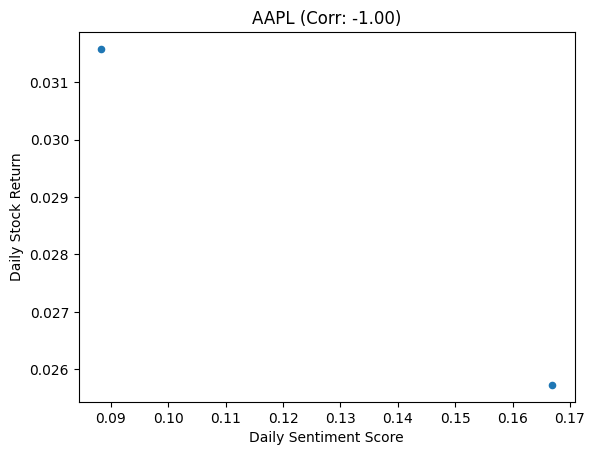

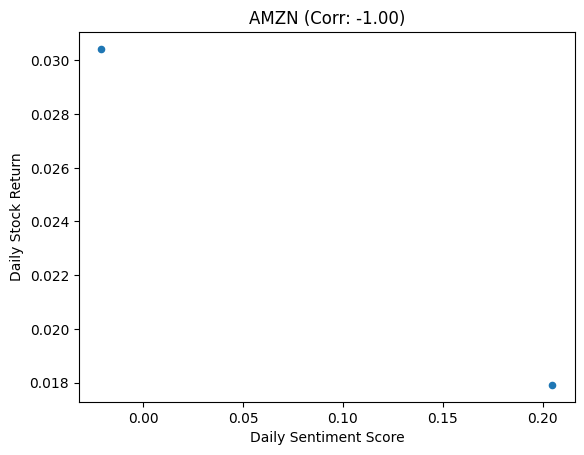

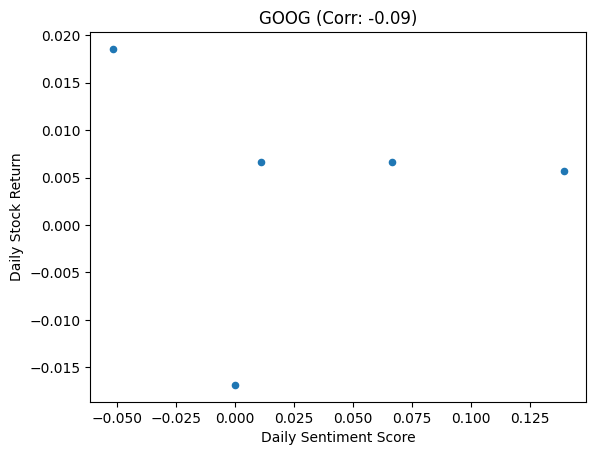

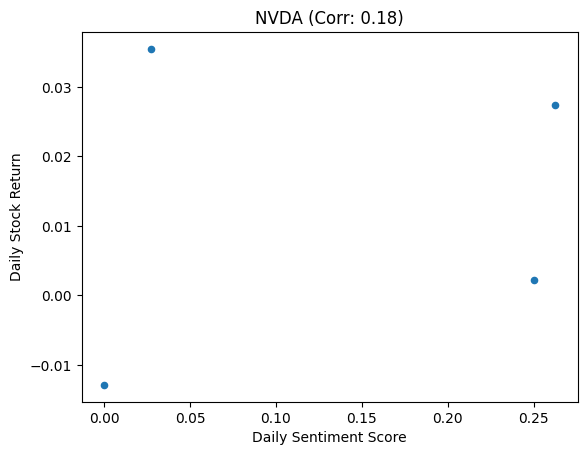

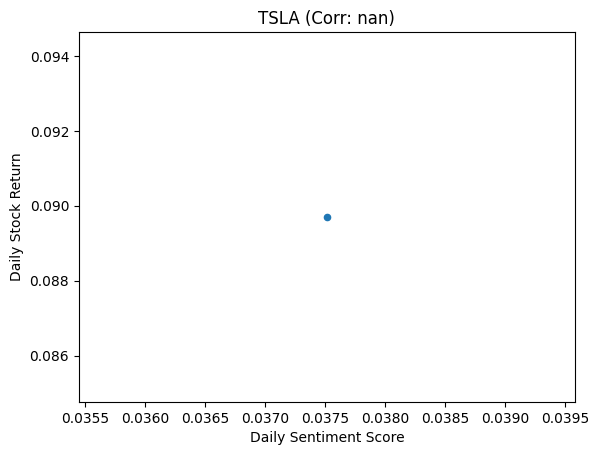

  ticker  correlation  observations
3   NVDA     0.175714             4
2   GOOG    -0.089449             5
0   AAPL    -1.000000             2
1   AMZN    -1.000000             2
4   TSLA          NaN             1


In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sentiment_analysis import analyze_sentiment
from data_loader import load_all_data

def clean_stock_data(df: pd.DataFrame) -> pd.DataFrame:
    """Clean individual stock data and calculate daily returns."""
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df.dropna(subset=['Date', 'Close'], inplace=True)
    df['Daily_Return'] = df['Close'].pct_change()
    df.set_index('Date', inplace=True)
    df.drop_duplicates(inplace=True)
    return df

def main():
    # Load and process data
    ratings, stocks = load_all_data()
    ratings = analyze_sentiment(ratings)

    # Prepare correlation analysis
    results = []
    for ticker, data in stocks.items():
        if ticker in ratings['stock'].unique():
            # Get daily sentiment
            daily_sentiment = ratings[ratings['stock'] == ticker].groupby(
                pd.Grouper(key='date', freq='D')
            )['enhanced_sentiment'].mean()
            
            # Ensure daily_sentiment is timezone-aware
            if daily_sentiment.index.tz is None:
                daily_sentiment.index = daily_sentiment.index.tz_localize('UTC')

            # Get daily returns
            returns = data['Daily_Return'].rename('returns')
            
            # Ensure returns index is timezone-aware
            if returns.index.tz is None:
                returns.index = returns.index.tz_localize('UTC')

            # Merge and calculate correlation
            merged = pd.merge(
                daily_sentiment, 
                returns, 
                left_index=True, 
                right_index=True
            ).dropna()
            
            if not merged.empty:
                corr = merged.corr().iloc[0, 1]
                results.append({
                    'ticker': ticker,
                    'correlation': corr,
                    'observations': len(merged)
                })
                
                # Plot for visual inspection
                merged.plot.scatter(
                    x='enhanced_sentiment', 
                    y='returns',
                    title=f'{ticker} (Corr: {corr:.2f})'
                )
                plt.xlabel('Daily Sentiment Score')
                plt.ylabel('Daily Stock Return')
                plt.show()

    # Display results
    results_df = pd.DataFrame(results)
    print(results_df.sort_values('correlation', ascending=False))

if __name__ == "__main__":
    main()